**These are simple set of codes to Kickstart the Cluster and Kubeflow, I have referred this from multiple Open sources available**

### Table of contents:

- Set up EKS Cluster in AWS
- Set up Policies
- Create S3 Bucket
- Set up Kubeflow
- Setup Credintials for Cluster
- Launch the Kubelfow dashboard 
- Set up Notebook incase you want to do any development

In [ ]:
import sys

print('Python Version %s' % sys.version)

%%bash

source ~/.bash_profile

pip install awscli --upgrade --user

curl --silent --location "https://github.com/weaveworks/eksctl/releases/latest/download/eksctl_$(uname -s)_amd64.tar.gz" | tar xz -C /tmp

sudo mv /tmp/eksctl /usr/local/bin

eksctl version

curl --location -o ./kubectl https://amazon-eks.s3.us-west-2.amazonaws.com/1.15.10/2020-02-22/bin/linux/amd64/kubectl

chmod +x ./kubectl

sudo mv ./kubectl /usr/local/bin

kubectl version --short --client
#### Install `aws-iam-authenticator`


curl -o aws-iam-authenticator https://amazon-eks.s3.us-west-2.amazonaws.com/1.15.10/2020-02-22/bin/linux/amd64/aws-iam-authenticator

chmod +x ./aws-iam-authenticator

sudo mv aws-iam-authenticator /usr/local/bin

aws-iam-authenticator version

sudo yum -y install jq gettext


for command in kubectl jq envsubst
  do
    which $command &>/dev/null && echo "$command in path" || echo "$command NOT FOUND"
  done

In [ ]:
##Configure the Environment Variables

%%bash

source ~/.bash_profile

export AWS_REGION=$(aws configure get region)
echo "export AWS_REGION=${AWS_REGION}" | tee -a ~/.bash_profile

export AWS_CLUSTER_NAME=aiworkshop
echo "export AWS_CLUSTER_NAME=${AWS_CLUSTER_NAME}" | tee -a ~/.bash_profile

## Create the EKS Cluster

In [3]:

%%bash

source ~/.bash_profile

cat << EOF > cluster.yaml
---
apiVersion: eksctl.io/v1alpha5
kind: ClusterConfig

metadata:
  name: ${AWS_CLUSTER_NAME}
  region: ${AWS_REGION}
  version: "1.17"

cloudWatch:
  clusterLogging:
    enableTypes: ["*"]

managedNodeGroups:
- name: cpu-nodes
  instanceType: c5.xlarge
  volumeSize: 100
  desiredCapacity: 4
  iam:
    withAddonPolicies:
      albIngress: true

EOF

!cat cluster.yaml

In [ ]:

%%bash

source ~/.bash_profile

eksctl create cluster -f ./cluster.yaml

echo "Completed"

## Below is the output you will get in 15-25 minutes

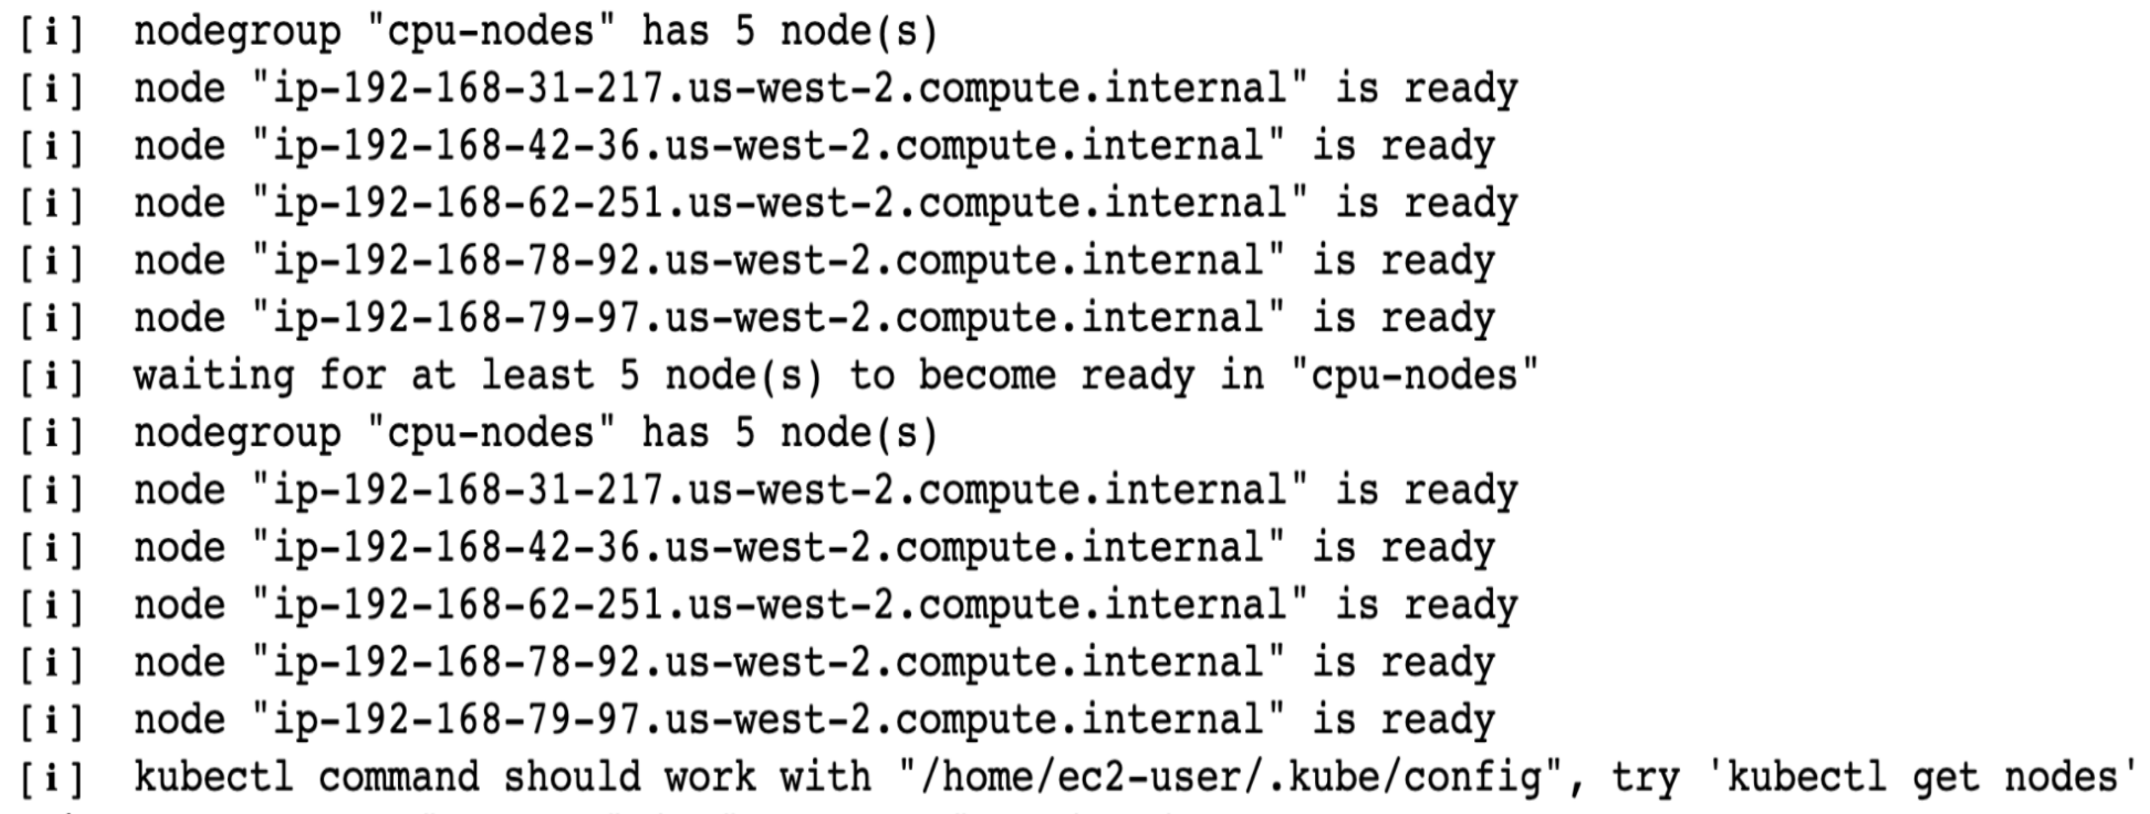

-------------------------------------------

## Add the IAM Policies with EKS Worker Nodes

In [ ]:


%%bash
source ~/.bash_profile

export INSTANCE_ROLE_NAME=$(aws iam list-roles \
    | jq -r ".Roles[] \
    | select(.RoleName \
    | startswith(\"eksctl-$AWS_CLUSTER_NAME\") and contains(\"NodeInstanceRole\")) \
    .RoleName")
echo "export INSTANCE_ROLE_NAME=${INSTANCE_ROLE_NAME}" | tee -a ~/.bash_profile

export INSTANCE_PROFILE_ARN=$(aws iam list-roles \
    | jq -r ".Roles[] \
    | select(.RoleName \
    | startswith(\"eksctl-$AWS_CLUSTER_NAME\") and contains(\"NodeInstanceRole\")) \
    .Arn")
echo "export INSTANCE_PROFILE_ARN=${INSTANCE_PROFILE_ARN}" | tee -a ~/.bash_profile

## Attach Roles

In [ ]:

%%bash

### Source the environment
source ~/.bash_profile

#### Allow Access from/to the Elastic Container Registry (ECR)
# This allows our cluster worker nodes to load custom Docker images (ie. models) from ECR.  We will load these custom Docker images in a later section.

aws iam attach-role-policy --role-name $INSTANCE_ROLE_NAME --policy-arn arn:aws:iam::aws:policy/AmazonEC2ContainerRegistryFullAccess

                    
!aws eks describe-cluster --name aiworkshop --query "cluster.identity.oidc.issuer" --output text

**The steps usually takes 15 Minutes, so please hold on till this is completed 
before you move forward**

## Config the EKS cluster

In [ ]:

%%bash

### Source the environment
source ~/.bash_profile

eksctl utils associate-iam-oidc-provider --cluster ${AWS_CLUSTER_NAME} --approve

%%bash

### Source the environment
source ~/.bash_profile

aws eks describe-cluster --name ${AWS_CLUSTER_NAME} --region ${AWS_REGION} --query "cluster.identity.oidc.issuer" --output text


## Verify Your EKS Cluster

In [ ]:

%%bash

kubectl get ns

%%bash

kubectl get nodes

## Create S3 Bucket

In [ ]:
%%bash

export S3_BUCKET=sagemaker-$(aws configure get region)-$(aws sts get-caller-identity | jq -r '.Account')
echo "export S3_BUCKET=${S3_BUCKET}" | tee -a ~/.bash_profile

# Create a new S3 bucket and upload the dataset. 
aws s3 ls s3://$S3_BUCKET || aws s3 mb s3://${S3_BUCKET}
        
%%bash
source ~/.bash_profile

%%bash

source ~/.bash_profile

echo "${S3_BUCKET}"

%%bash

source ~/.bash_profile

aws s3 ls s3://${S3_BUCKET}

## Setup Kubeflow on EKS

In [ ]:
%%bash

source ~/.bash_profile

echo $S3_BUCKET
echo $AWS_CLUSTER_NAME
echo $INSTANCE_ROLE_NAME
echo $INSTANCE_PROFILE_ARN


sudo cp kfext/kfctl /usr/local/bin

%%bash

source ~/.bash_profile

#### Set Kubeflow environment variables 
export KF_NAME=${AWS_CLUSTER_NAME}
echo "export KF_NAME=${KF_NAME}" | tee -a ~/.bash_profile

export KF_DIR=$PWD/${KF_NAME}
echo "export KF_DIR=${KF_DIR}" | tee -a ~/.bash_profile

mkdir -p ${KF_DIR}

%%bash

source ~/.bash_profile

cp kfext/v1.0.2.tar.gz ${KF_DIR}
cp kfext/kfctl_aws.v1.0.2.yaml ${KF_DIR}


%%bash

source ~/.bash_profile

export CONFIG_FILE=${KF_DIR}/kfctl_aws.v1.0.2.yaml
echo "export CONFIG_FILE=${CONFIG_FILE}" | tee -a ~/.bash_profile

In [ ]:
%%bash

source ~/.bash_profile

sed -i.bak -e "/region: us-west-2/ a \      enablePodIamPolicy: true" ${CONFIG_FILE}
sed -i.bak -e "s@us-west-2@$AWS_REGION@" ${CONFIG_FILE}
sed -i.bak -e "s@roles:@#roles:@" ${CONFIG_FILE}
sed -i.bak -e "s@- eksctl-kubeflow-aws-nodegroup-ng-a2-NodeInstanceRole-xxxxxxx@#- eksctl-kubeflow-aws-nodegroup-ng-a2-NodeInstanceRole-xxxxxxx@" ${CONFIG_FILE}
sed -i.bak -e "s@eksctl-kubeflow-aws-nodegroup-ng-a2-NodeInstanceRole-xxxxxxx@$INSTANCE_ROLE_NAME@" ${CONFIG_FILE}
sed -i.bak -e 's/kubeflow-aws/'"$AWS_CLUSTER_NAME"'/' ${CONFIG_FILE}

%%bash

source ~/.bash_profile

#### Generate the Kubeflow installation files

cd ${KF_DIR}

rm -rf kustomize
rm -rf .cache

kfctl build -V -f ${CONFIG_FILE}

#### Deploy Kubeflow

cd ${KF_DIR}

kfctl apply -V -f ${CONFIG_FILE}

kubectl delete all -l app=spartakus --namespace=kubeflow

kubectl config set-context --current --namespace=kubeflow

--------------------------------------------

## We need to wait for the above code to run and the Resource to become available

**Use the below code check after 15 minutes if all your resources are ready**

In [ ]:
!kubectl -n kubeflow get all

!kubectl -n istio-system get all

-------------------------------------------

## Setup AWS Credentials in EKS cluster

In [ ]:
%%bash

source ~/.bash_profile

aws iam create-user --user-name s3user
aws iam attach-user-policy --user-name s3user --policy-arn arn:aws:iam::aws:policy/AmazonS3FullAccess
aws iam attach-user-policy --user-name s3user --policy-arn arn:aws:iam::aws:policy/AmazonSageMakerFullAccess
aws iam attach-user-policy --user-name s3user --policy-arn arn:aws:iam::aws:policy/AmazonEC2ContainerRegistryFullAccess

In [ ]:
%%bash

source ~/.bash_profile

aws iam create-access-key --user-name s3user > /tmp/create_output.json


%%bash

source ~/.bash_profile

export AWS_ACCESS_KEY_ID_VALUE=$(jq -j .AccessKey.AccessKeyId /tmp/create_output.json | base64)
echo "export AWS_ACCESS_KEY_ID_VALUE=${AWS_ACCESS_KEY_ID_VALUE}" | tee -a ~/.bash_profile

export AWS_SECRET_ACCESS_KEY_VALUE=$(jq -j .AccessKey.SecretAccessKey /tmp/create_output.json | base64)
echo "export AWS_SECRET_ACCESS_KEY_VALUE=${AWS_SECRET_ACCESS_KEY_VALUE}" | tee -a ~/.bash_profile

#### Apply to EKS cluster.

#### Add the secret to the `kubeflow` namespace.  This is needed until KF Pipelines support namespaces.
cat <<EOF | kubectl apply --namespace kubeflow -f -
apiVersion: v1
kind: Secret
metadata:
  name: aws-secret
type: Opaque
data:
  AWS_ACCESS_KEY_ID: $AWS_ACCESS_KEY_ID_VALUE
  AWS_SECRET_ACCESS_KEY: $AWS_SECRET_ACCESS_KEY_VALUE
EOF



In [ ]:
%%bash

source ~/.bash_profile

TRUST="{ \"Version\": \"2012-10-17\", \"Statement\": [ { \"Effect\": \"Allow\", \"Principal\": { \"Service\": \"sagemaker.amazonaws.com\" }, \"Action\": \"sts:AssumeRole\" } ] }"
aws iam create-role --role-name workshop-sagemaker-kfp-role --assume-role-policy-document "$TRUST"
aws iam attach-role-policy --role-name workshop-sagemaker-kfp-role --policy-arn arn:aws:iam::aws:policy/AmazonS3FullAccess
aws iam attach-role-policy --role-name workshop-sagemaker-kfp-role --policy-arn arn:aws:iam::aws:policy/AmazonSageMakerFullAccess

export SAGEMAKER_ROLE_ARN=$(aws iam get-role --role-name workshop-sagemaker-kfp-role --output text --query 'Role.Arn')
echo "export SAGEMAKER_ROLE_ARN=${SAGEMAKER_ROLE_ARN}" | tee -a ~/.bash_profile

cat <<EoF > sagemaker-invoke.json
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "sagemaker:InvokeEndpoint"
            ],
            "Resource": "*"
        }
    ]
}
EoF

aws iam put-role-policy --role-name workshop-sagemaker-kfp-role --policy-name sagemaker-invoke-for-worker --policy-document file://sagemaker-invoke.json
aws iam put-role-policy --role-name ${INSTANCE_ROLE_NAME} --policy-name sagemaker-invoke-for-worker --policy-document file://sagemaker-invoke.json



!cat sagemaker-invoke.json

In [ ]:
%%bash

source ~/.bash_profile

cat <<EoF > sagemaker-full.json
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "sagemaker:*"
            ],
            "Resource": "*"
        }
    ]
}
EoF

aws iam put-role-policy --role-name workshop-sagemaker-kfp-role --policy-name sagemaker-invoke-for-worker --policy-document file://sagemaker-full.json
aws iam put-role-policy --role-name ${INSTANCE_ROLE_NAME} --policy-name sagemaker-invoke-for-worker --policy-document file://sagemaker-full.json

!cat sagemaker-full.json

In [ ]:
%%bash

source ~/.bash_profile

aws iam attach-role-policy --role-name ${INSTANCE_ROLE_NAME} --policy-arn arn:aws:iam::aws:policy/AmazonS3FullAccess
aws iam attach-role-policy --role-name ${INSTANCE_ROLE_NAME} --policy-arn arn:aws:iam::aws:policy/AmazonSageMakerFullAccess

----------------------------

## Launch the Kubeflow Dashboard

In [ ]:
%%bash

source ~/.bash_profile


## THIS IS A PUBLIC ENDPOINT

cd ${KF_DIR}/.cache/manifests/manifests-1.0.2/
kubectl apply -k aws/istio-ingress/base --namespace istio-system
cd ${KF_DIR}

In [ ]:
%%bash

echo "********************************************************"
echo "        CLICK THE FOLLOWING LINK WHEN IT APPEARS        "
echo ""
echo http://$(kubectl get ingress -n istio-system -o jsonpath='{.items[0].status.loadBalancer.ingress[0].hostname}')
echo ""
echo "^^^^^^ COPY/PASTE THIS URL INTO A NEW BROWSER TAB ^^^^^^"
echo "********************************************************"


## Once you see a URL above follow the below Screen shot

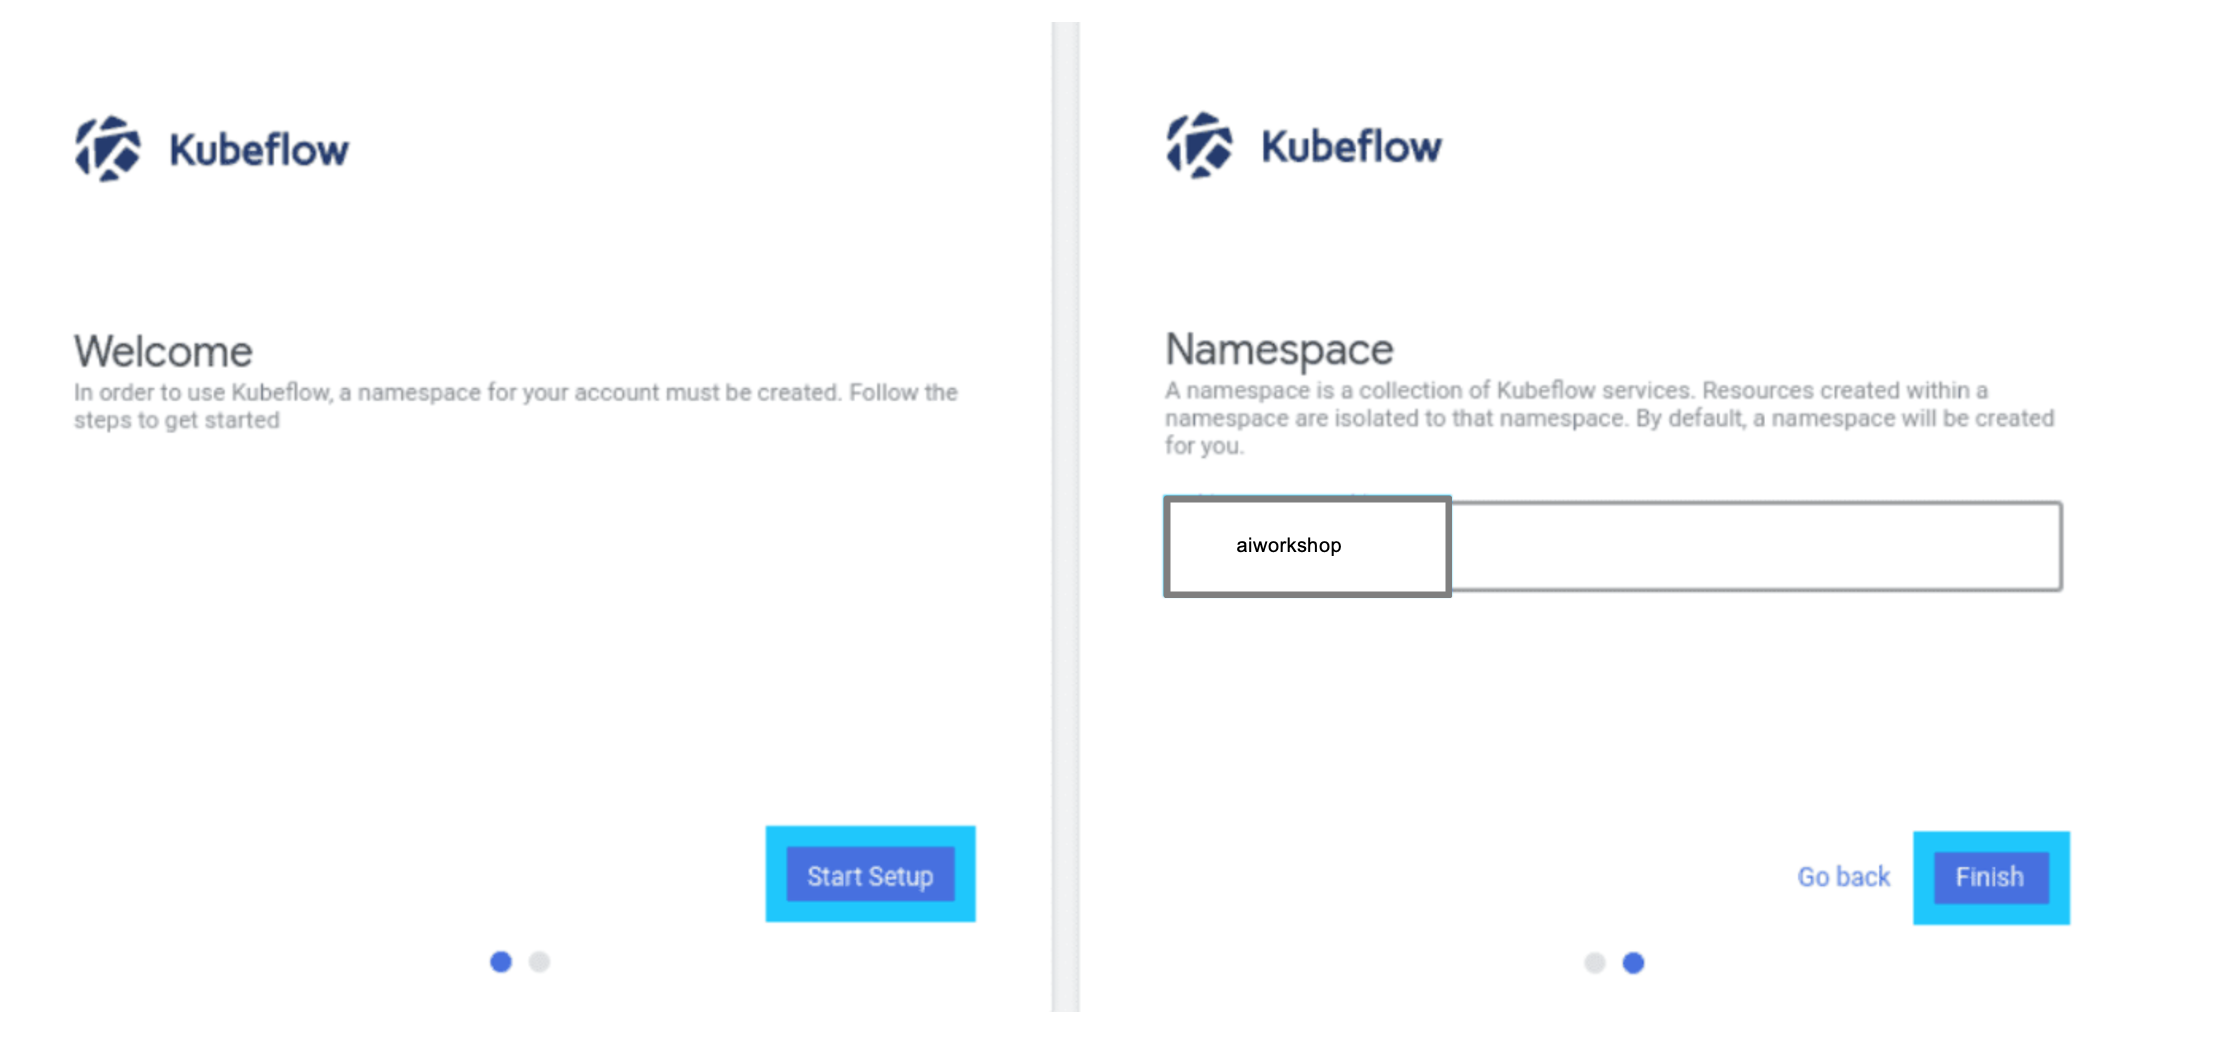

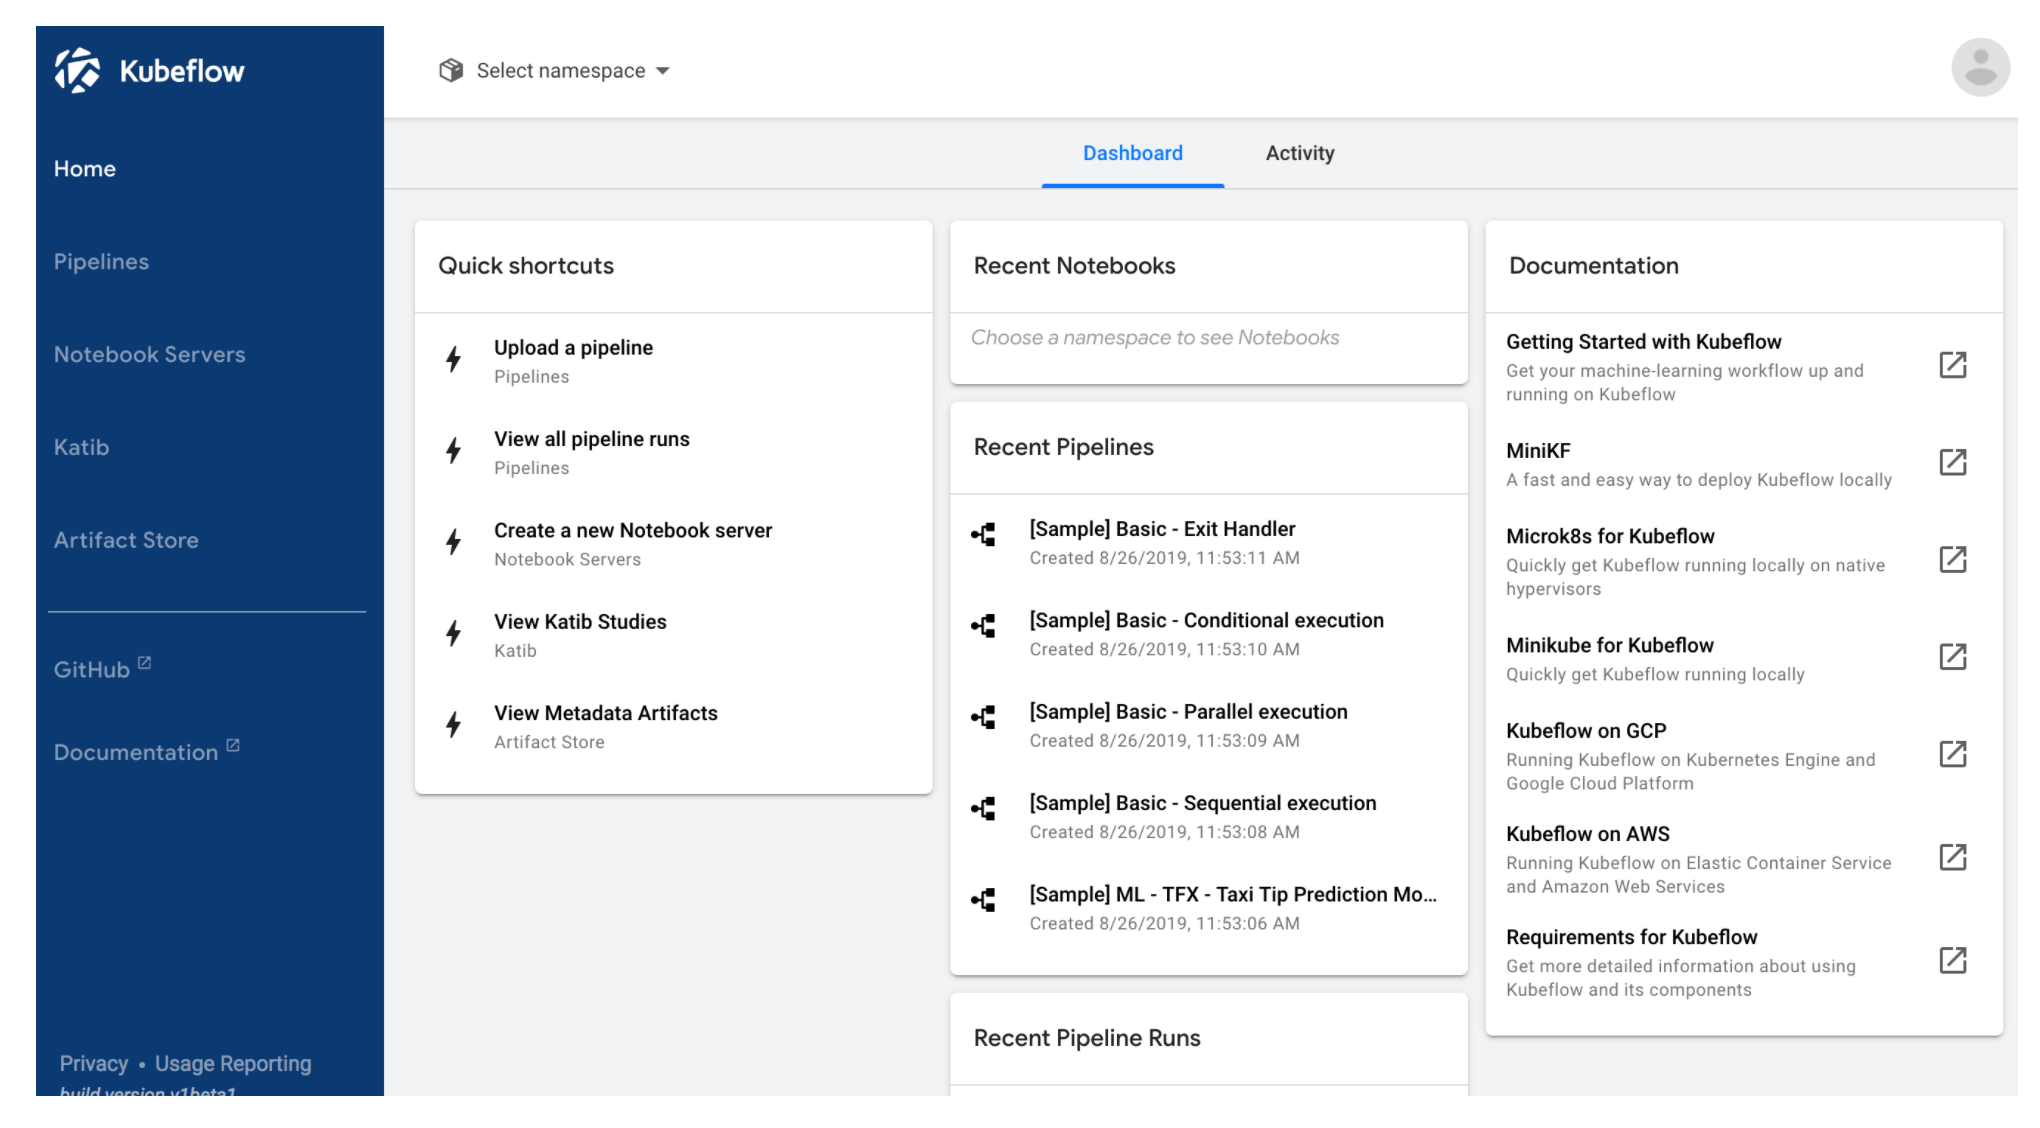

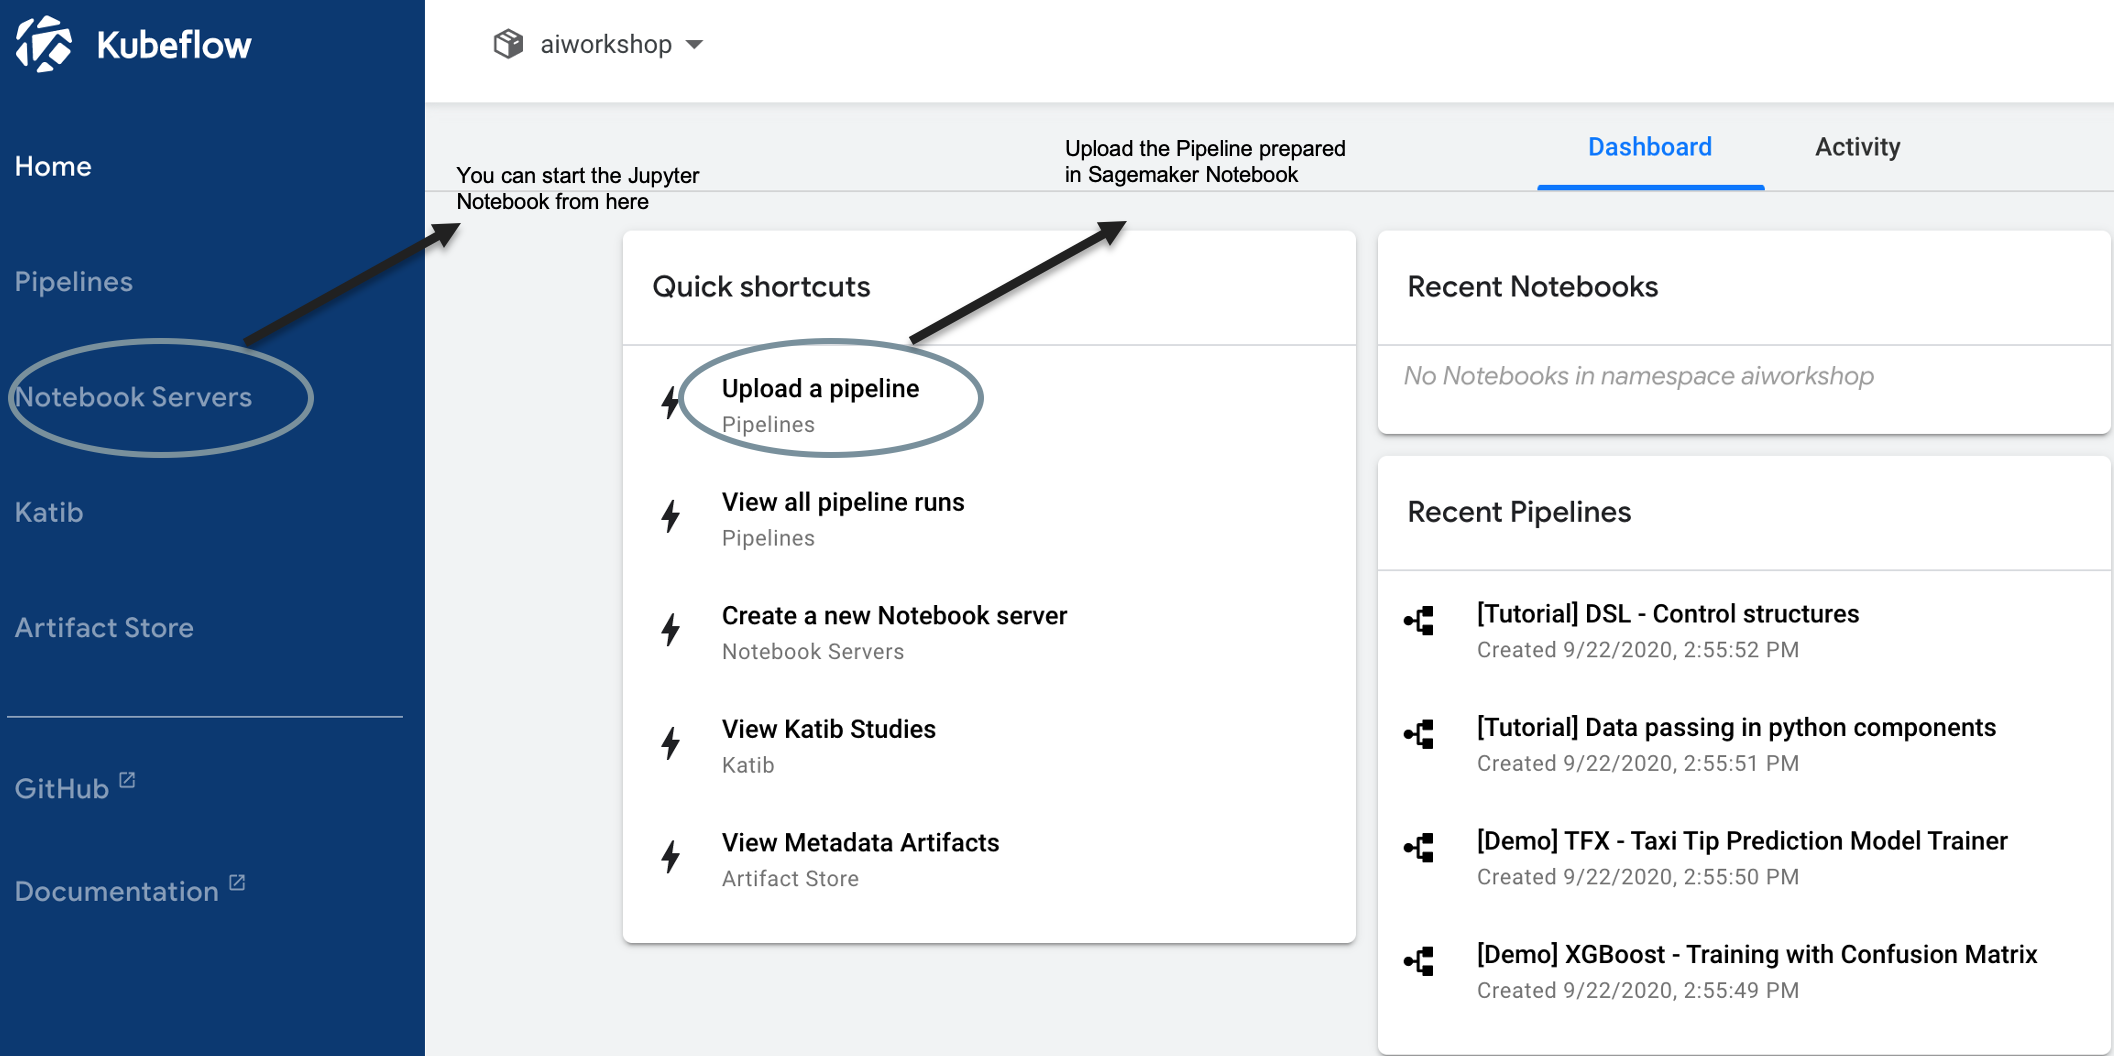

## Create your Notebook server

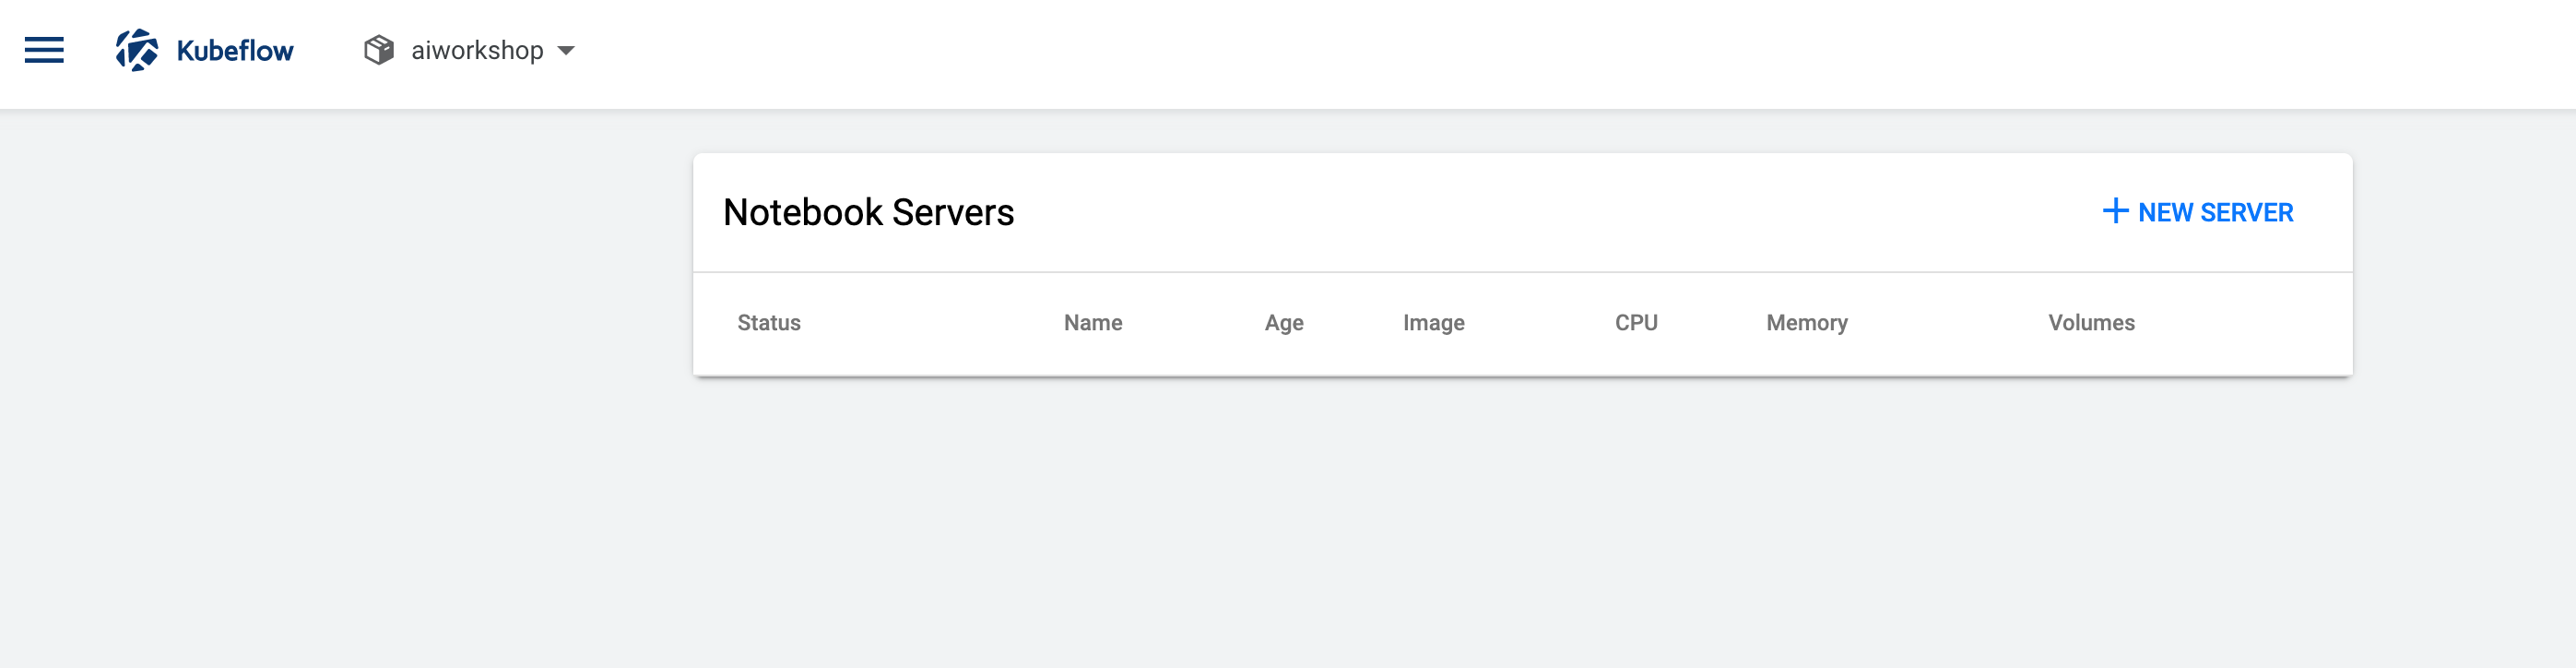

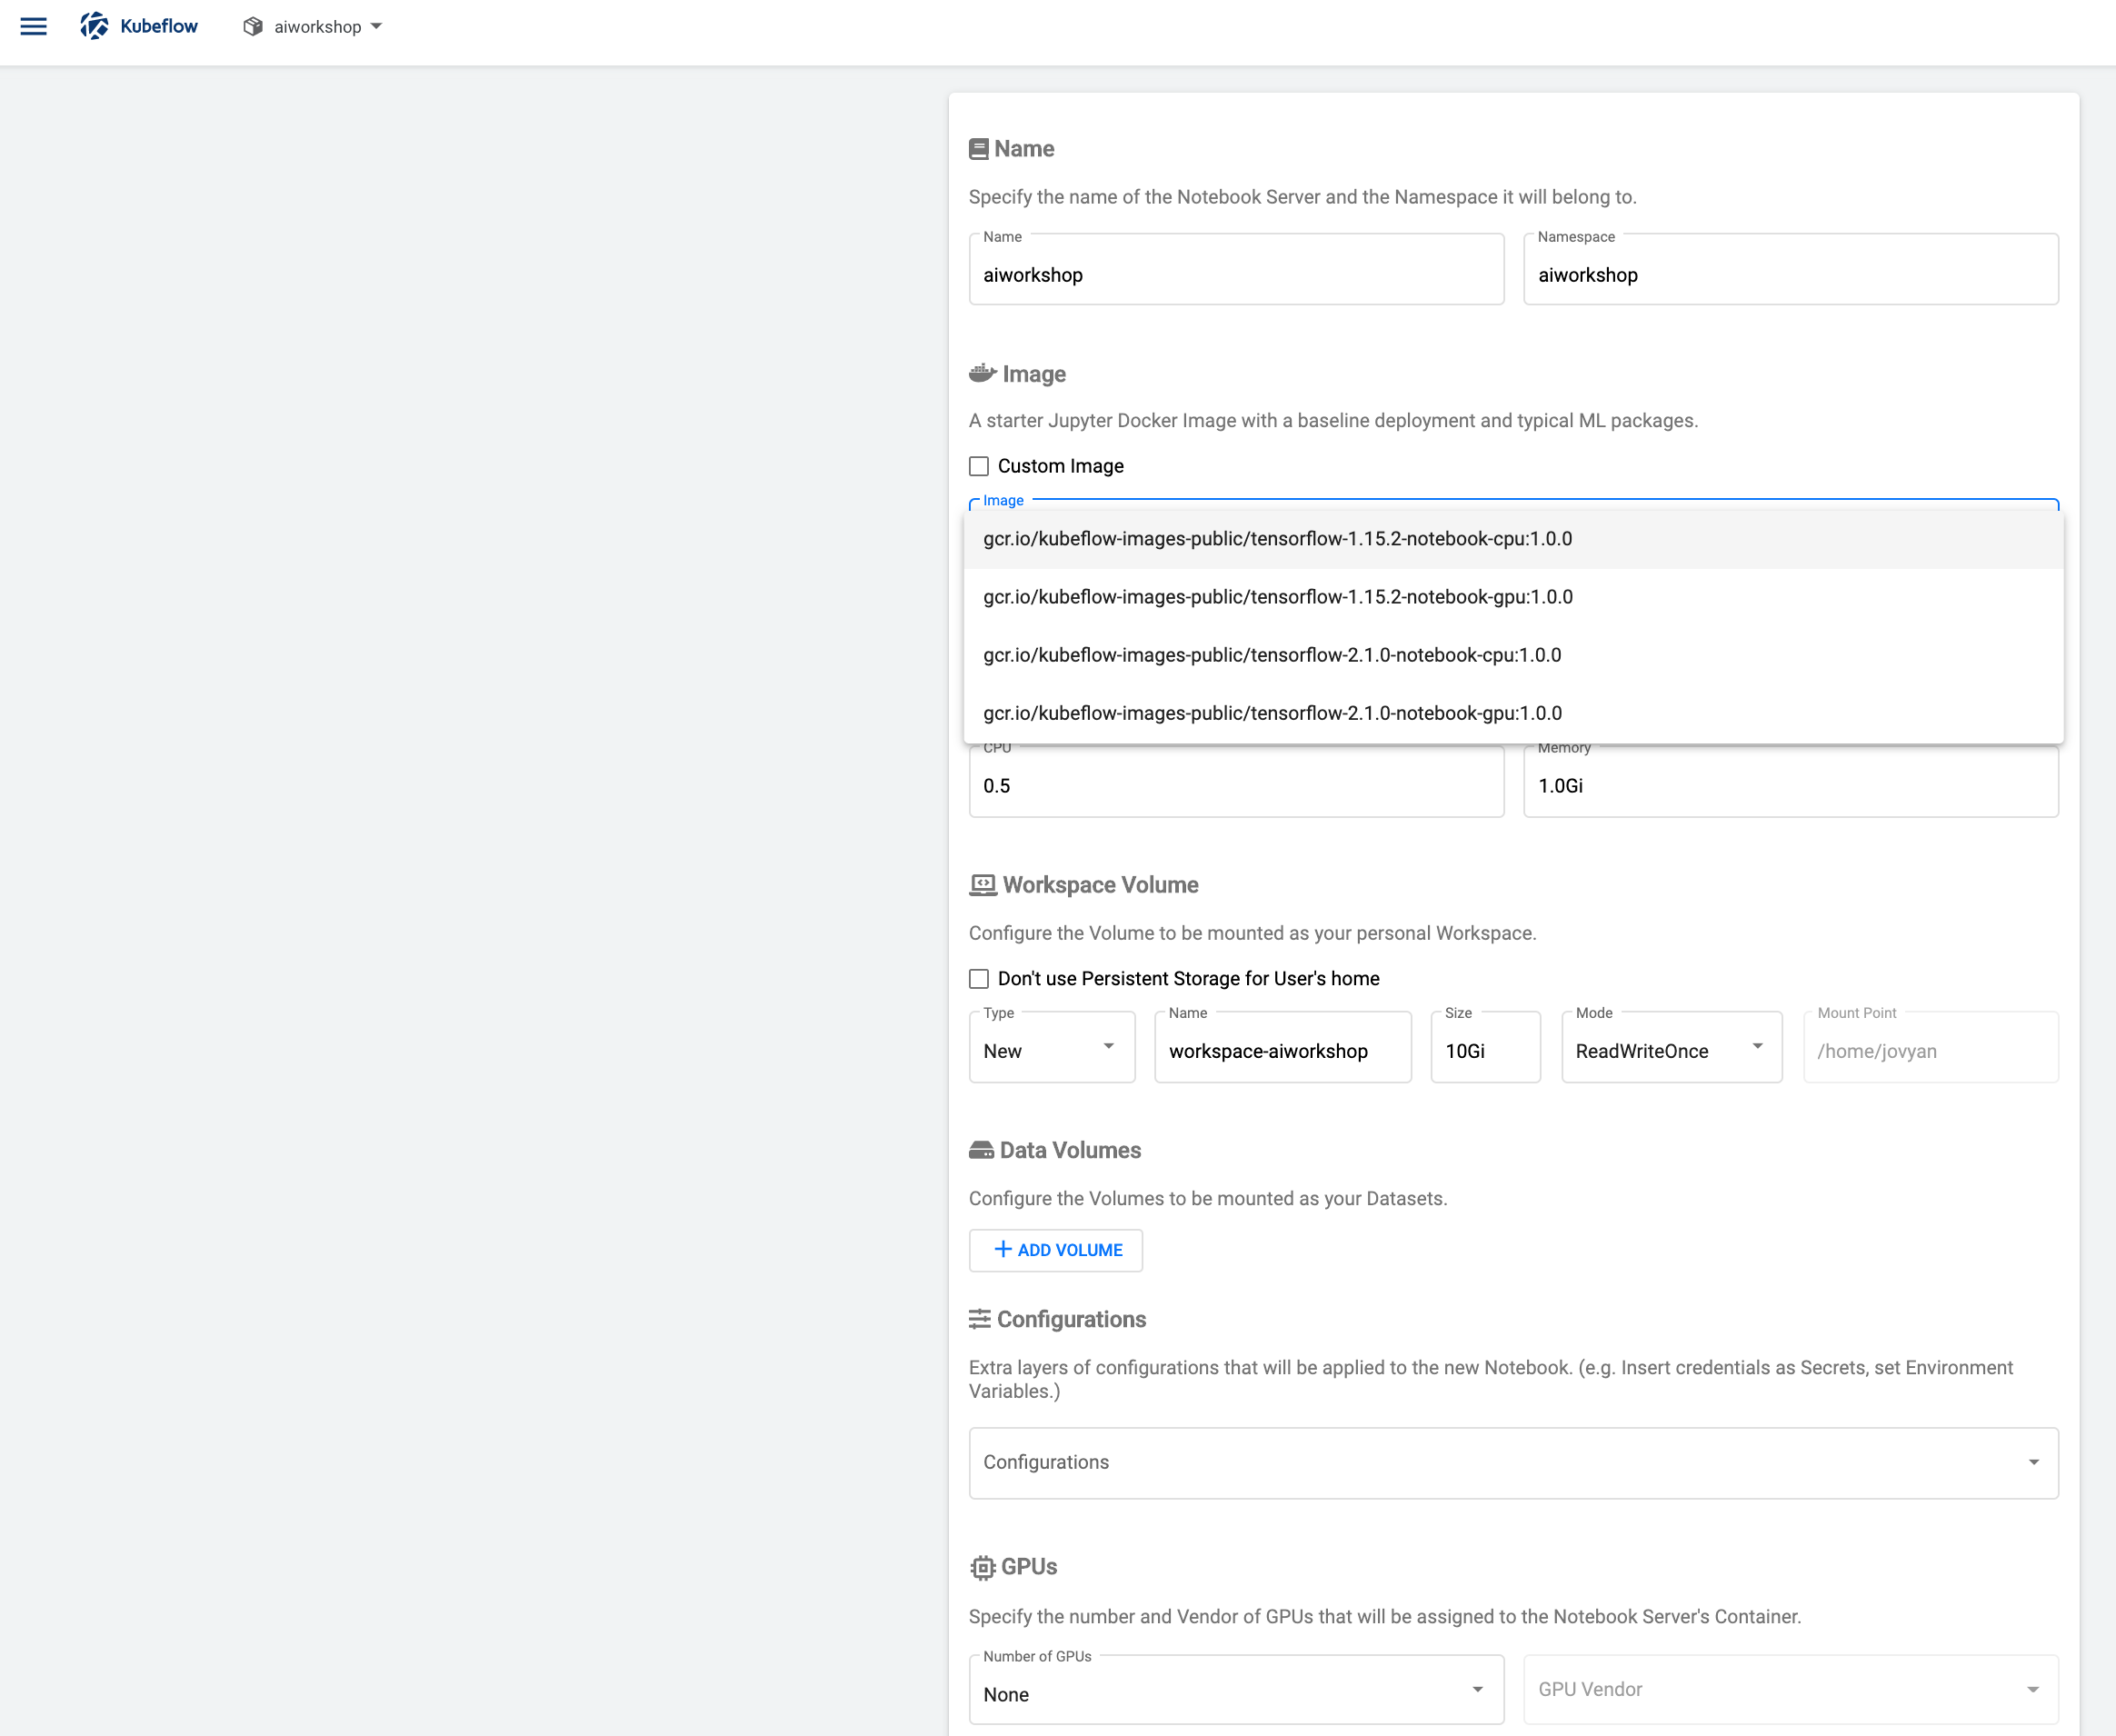

## Select New Terminal in the Notebook

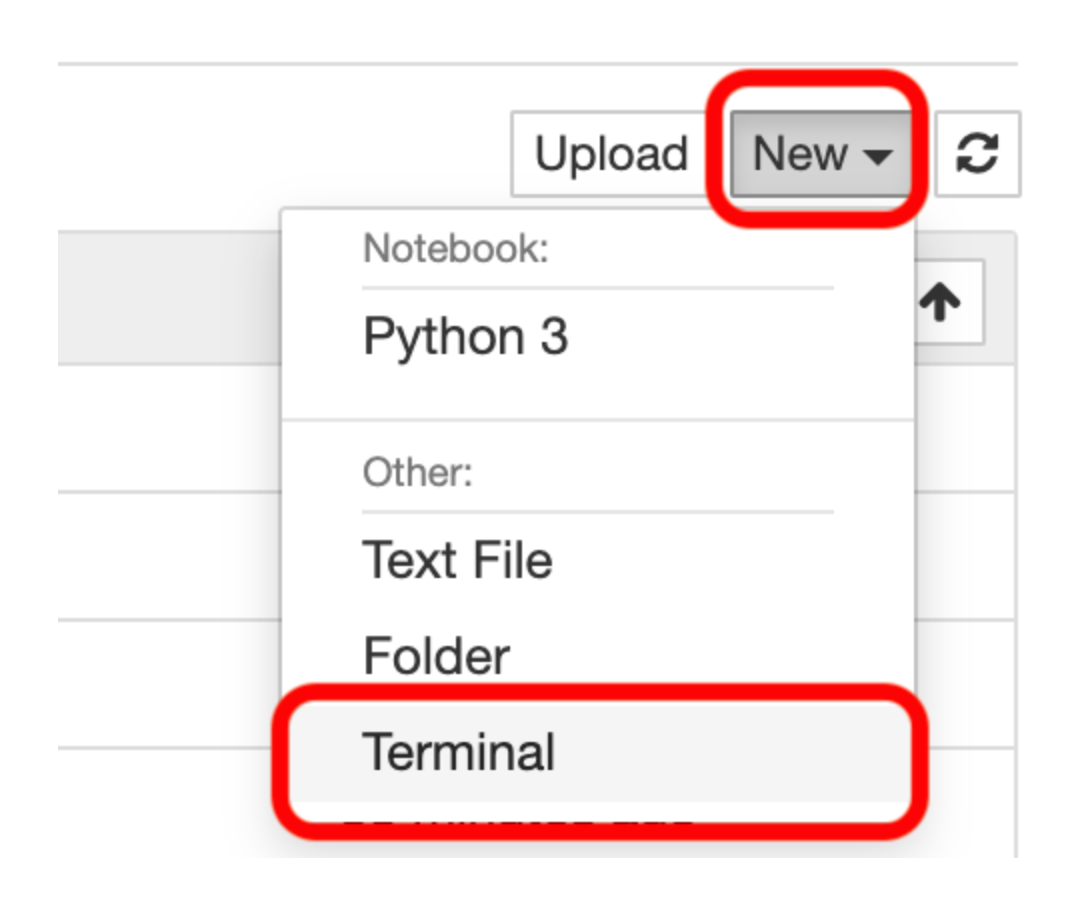

#### You can clone any Repo and start working based on your requirement